In [16]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from pyspark.sql import SparkSession
from pyspark.sql.functions import asc, lit

##### Testing for 1 Flight Trip

In [17]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Rogue Generator") \
    .getOrCreate()

flights_file_path = os.path.join('dataset', 'raw', '0d02a8', '0d02a8_0.parquet')

read_one_flight = spark.read.parquet(flights_file_path, header=True)

In [18]:
def get_values_from_selected_columns(flight_data):
    default_signature_label = 0

    selected_cols = flight_data.select('time', 'icao24', 'lat', 'lon', 'heading', 'baroaltitude', 
                                     'geoaltitude', 'lastposupdate', 'lastcontact' , 'velocity', 'dropout_length') \
                        .orderBy(asc('time'))
    
    selected_cols = selected_cols.withColumn("signature", lit(default_signature_label)) # Adding new column for capturing anomaly signature

    return selected_cols

In [19]:
one_flight = get_values_from_selected_columns(read_one_flight)

In [20]:
one_flight.show(3)

+----------+------+-----------------+------------------+------------------+------------------+------------------+----------------+----------------+------------------+--------------+---------+
|      time|icao24|              lat|               lon|           heading|      baroaltitude|       geoaltitude|   lastposupdate|     lastcontact|          velocity|dropout_length|signature|
+----------+------+-----------------+------------------+------------------+------------------+------------------+----------------+----------------+------------------+--------------+---------+
|1645229867|0d02a8|30.18530894134004|-95.45196533203125|173.72671649091603|3596.6400000000003|2926.0800000000004|1.645229866313E9|1.645229866313E9|145.94713719703776|          null|        0|
|1645229868|0d02a8|30.18530894134004|-95.45196533203125|173.72671649091603|3596.6400000000003|2926.0800000000004|1.645229866313E9|1.645229866313E9|145.94713719703776|           0.0|        0|
|1645229869|0d02a8|30.18530894134004|-95

In [21]:
def convert_to_pandas(get_flights):
    return get_flights.toPandas()

In [22]:
one_flight_df = convert_to_pandas(one_flight)

In [23]:
one_flight_df.head(3)

,time,icao24,lat,lon,heading,baroaltitude,geoaltitude,lastposupdate,lastcontact,velocity,dropout_length,signature
0,1645229867,0d02a8,30.185309,-95.451965,173.726716,3596.64,2926.08,1.645230e+09,1.645230e+09,145.947137,NaN,0
1,1645229868,0d02a8,30.185309,-95.451965,173.726716,3596.64,2926.08,1.645230e+09,1.645230e+09,145.947137,0.0,0
2,1645229869,0d02a8,30.185309,-95.451965,173.726716,3596.64,2926.08,1.645230e+09,1.645230e+09,145.947137,0.0,0


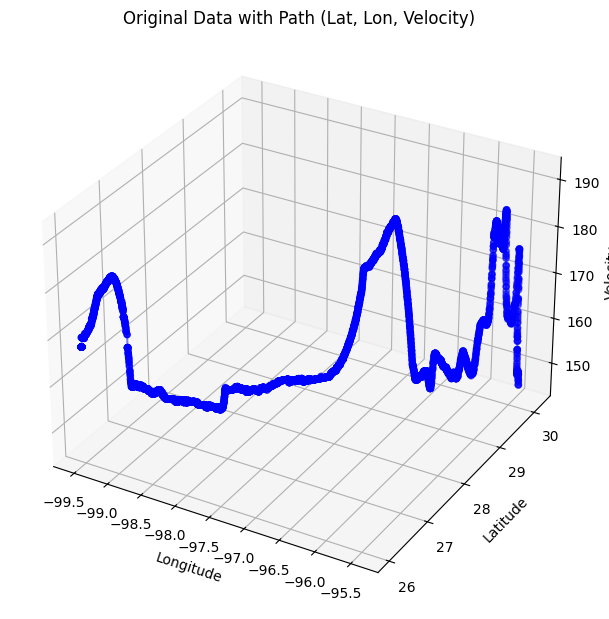

In [24]:
# Create 3D plots for original data paths
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')

# Plot original data with path
ax1.scatter(one_flight_df['lon'], one_flight_df['lat'], one_flight_df['velocity'], c='blue', label='Original Data')
ax1.plot(one_flight_df['lon'], one_flight_df['lat'], one_flight_df['velocity'], c='blue', alpha=0.5, label='Path')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_zlabel('Velocity')
ax1.set_title('Original Data with Path (Lat, Lon, Velocity)')

plt.tight_layout()
plt.show()

##### Introducing Noise using Akima Interpolation

##### a. Velocity Alone

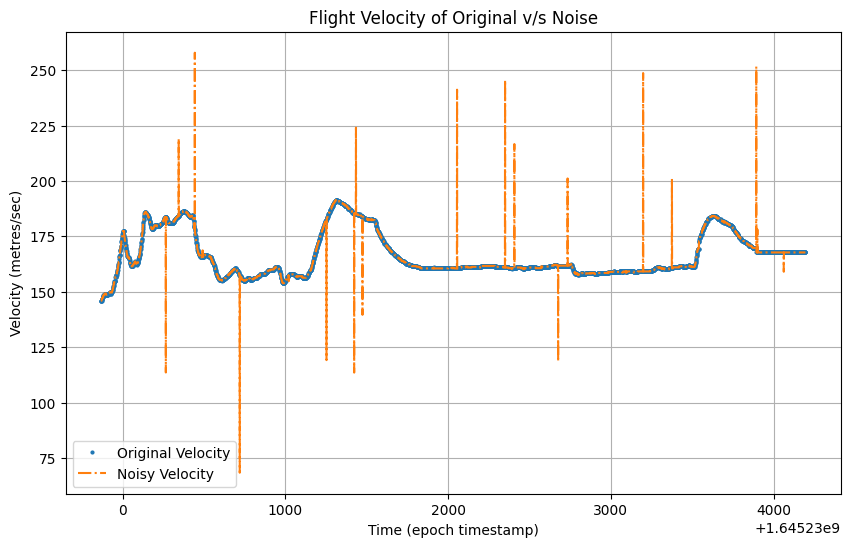

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Akima1DInterpolator


timestamps = np.copy(one_flight_df['time'])      # epochs timestamp
latitudes = np.copy(one_flight_df['lat'])        # deg
longitudes = np.copy(one_flight_df['lon'])       # deg
velocity = np.copy(one_flight_df['velocity'])    # meters/sec
signature_label = np.copy(one_flight_df['signature'])

num_points = 20
noise_level = 100


start_time = timestamps[0]
end_time = timestamps[-1]

random_indices = np.random.choice(len(timestamps), num_points, replace=False)

while any(np.isclose(random_indices, start_time)) or any(np.isclose(random_indices, end_time)):
    random_indices = np.random.uniform(start_time, end_time, num_points)

for i in random_indices:
    latitudes[i] += np.random.uniform(-noise_level, noise_level)
    longitudes[i] += np.random.uniform(-noise_level, noise_level)
    velocity[i] += np.random.uniform(-noise_level, noise_level)
    signature_label[i] = 1

# Plot the original velocity, interpolated velocity, and noisy velocity
plt.figure(figsize=(10, 6))
plt.plot(one_flight_df['time'], one_flight_df['velocity'], 'o', label='Original Velocity', markersize=2)
# plt.plot(one_flight_df['time'], one_flight_df['velocity'], label='Interpolated Velocity', linestyle='--')
plt.plot(timestamps, velocity, label='Noisy Velocity', linestyle='-.')
plt.legend()
plt.title('Flight Velocity of Original v/s Noise')
plt.xlabel('Time (epoch timestamp)')
plt.ylabel('Velocity (metres/sec)')
plt.grid(True)
plt.show()

#### Attack on Multiple Trips

In [26]:
def invoke_rogue_generator(one_flight_df):
    timestamps = np.copy(one_flight_df['time'])      # epochs timestamp
    latitudes = np.copy(one_flight_df['lat'])        # deg
    longitudes = np.copy(one_flight_df['lon'])       # deg
    velocity = np.copy(one_flight_df['velocity'])    # meters/sec
    signature_label = np.copy(one_flight_df['signature'])

    num_points = 20
    noise_level = 100


    start_time = timestamps[0]
    end_time = timestamps[-1]

    random_indices = np.random.choice(len(timestamps), num_points, replace=False)

    while any(np.isclose(random_indices, start_time)) or any(np.isclose(random_indices, end_time)):
        random_indices = np.random.uniform(start_time, end_time, num_points)

    for i in random_indices:
        # latitudes[i] += np.random.uniform(-noise_level, noise_level)
        # longitudes[i] += np.random.uniform(-noise_level, noise_level)
        velocity[i] += np.random.uniform(-noise_level, noise_level)
        signature_label[i] = 1

    new_time_values = timestamps
    
    return new_time_values, latitudes, longitudes, velocity, signature_label

In [27]:
flight_attack_dict = [
    {
        'flight_icao24': '0d02a8',
        'trip_number': 0
    },
    {
        'flight_icao24': '0d02a8',
        'trip_number': 2
    },
    {
        'flight_icao24': 'a007c6',
        'trip_number': 0
    },
    {
        'flight_icao24': 'a007c6',
        'trip_number': 4
    }
]

In [28]:
for value in flight_attack_dict:
    flights_file_path = os.path.join('dataset', 'raw', value["flight_icao24"], f'{value["flight_icao24"] + "_" + str(value["trip_number"])}.parquet')


    read_one_flight = spark.read.parquet(flights_file_path, header=True)

    selected_df = read_one_flight.select('time', 'icao24', 'lat', 'lon', 'heading', 'baroaltitude', 
                                        'geoaltitude', 'velocity', 'icao24', 'flight_number') \
                            .orderBy(asc('time'))


    default_signature_label = 0
    selected_df = selected_df.withColumn("signature", lit(default_signature_label))
    selected_df = selected_df.toPandas()

    new_time_values, new_lat_coordinates, new_lon_coordinates, new_velocity, signature_label = invoke_rogue_generator(selected_df)

    data = {'time': new_time_values, 
        'latitude': new_lat_coordinates, 
        'longitude': new_lon_coordinates,
        'velocity': new_velocity,
        'velocity': selected_df['velocity'],
        'heading': selected_df['heading'],
        'baroaltitude': selected_df['baroaltitude'],
        'geoaltitude': selected_df['geoaltitude'],
        'signature_label' : signature_label,
        'icao24': value["flight_icao24"],
        'trip_number': value["trip_number"]}

    df = pd.DataFrame(data)
    file_name = f'{value["flight_icao24"] + "_" + str(value["trip_number"]) + ".csv"}'
    df.to_csv(os.path.join('dataset', 'processed', file_name))

#### Good Flight Trips

In [29]:
good_flights = [
    {
        'flight_icao24': '0d02a8',
        'trip_number': 1
    },
    {
        'flight_icao24': 'a007c6',
        'trip_number': 1
    },
    {
        'flight_icao24': 'a007c6',
        'trip_number': 2
    },
    {
        'flight_icao24': 'a007c6',
        'trip_number': 3
    }
]

In [30]:
for value in good_flights:
    flights_file_path = os.path.join('dataset', 'raw', value["flight_icao24"], f'{value["flight_icao24"] + "_" + str(value["trip_number"])}.parquet')


    read_one_flight = spark.read.parquet(flights_file_path, header=True)

    rem_df = read_one_flight.select('time', 'icao24', 'lat', 'lon', 'heading', 'baroaltitude', 
                                        'geoaltitude', 'velocity', 'icao24', 'flight_number') \
                            .orderBy(asc('time'))


    default_signature_label = 0
    rem_df = rem_df.withColumn("signature_label", lit(default_signature_label))

    rem_df = rem_df.toPandas()

    data = {'time': rem_df['time'], 
        'latitude': rem_df['lat'], 
        'longitude': rem_df['lon'],
        'velocity': rem_df['velocity'],
        'heading': rem_df['heading'],
        'baroaltitude': rem_df['baroaltitude'],
        'geoaltitude': rem_df['geoaltitude'],
        'signature_label' : rem_df['signature_label'],
        'icao24': value["flight_icao24"],
        'trip_number': value["trip_number"]}

    df = pd.DataFrame(data)
    file_name = f'{value["flight_icao24"] + "_" + str(value["trip_number"]) + ".csv"}'

    df.to_csv(os.path.join('dataset', 'processed', file_name))